## Description  
This notebook implements a full pipeline to analyze linguistic features related to self-belief and emotional stability,  
focusing on individuals with Borderline Personality Disorder (BPD). It computes sentence- and user-level scores for four  
key NLP tasks: self-belief detection, emotion classification, sentiment analysis, and contradiction detection.  
It also includes unsupervised topic modeling to identify dominant BPD-related themes.  

## Install Libraries


In [ ]:
!pip install transformers torch pandas numpy scipy
!pip install bertopic
!pip install umap-learn hdbscan sentence-transformers

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 115.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 64.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 68.7 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitli

## Import libraries

In [ ]:
import re
from collections import defaultdict

import pandas as pd
import torch
import torch.nn.functional as F
from tqdm import tqdm
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from bertopic import BERTopic


## Data Preprocessing


In [ ]:
df = pd.read_csv("/content/BPD Users Full Reddit Data - Clean Cut by WC.csv")

# Group by user and count posts
user_post_counts = df.groupby('user').size().reset_index(name='post_count')

# Filter users with 100 to 1000 posts (inclusive)
users_in_range = user_post_counts[
    (user_post_counts['post_count'] >= 100) &
    (user_post_counts['post_count'] <= 500)
]

print(f"Number of users with 100 to 1000 posts: {len(users_in_range)}")
users_in_range.to_csv("users_100_to_500_posts.csv", index=False)


Number of users with 100 to 1000 posts: 380


In [ ]:
# Filter original dataframe to include only users in range
filtered_df = df[df['user'].isin(users_in_range['user'])]

filtered_df.to_csv("posts_from_users_100_to_500.csv", index=False)
print(f"Extracted {filtered_df.shape[0]} posts from {len(users_in_range)} users.")

user_posts_df = filtered_df.groupby('user')['text'].apply(lambda posts: ' '.join(posts)).reset_index()
user_posts_df.columns = ['user_id', 'text']

user_posts_df.to_csv("concatenated_posts_100_to_500.csv", index=False)


Extracted 95966 posts from 380 users.


In [ ]:
filtered_df['date_posted'] = pd.to_datetime(filtered_df['date_posted'], dayfirst=True, errors='coerce')
filtered_df = filtered_df.dropna(subset=['date_posted'])
filtered_df = filtered_df.sort_values(by=['user', 'date_posted'])
filtered_df = filtered_df.reset_index(drop=True)

## Import models


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Self-Belief Classifier
self_model = AutoModelForSequenceClassification.from_pretrained("sidmangalik/SelfAwareNet").to(device)
self_tokenizer = AutoTokenizer.from_pretrained("roberta-base")

# Emotion Classifier
emotion_model = AutoModelForSequenceClassification.from_pretrained("j-hartmann/emotion-english-distilroberta-base").to(device)
emotion_tokenizer = AutoTokenizer.from_pretrained("j-hartmann/emotion-english-distilroberta-base")

# NLI Model (to detect contradiction)
nli_model = AutoModelForSequenceClassification.from_pretrained("roberta-large-mnli").to(device)
nli_tokenizer = AutoTokenizer.from_pretrained("roberta-large-mnli")

# Sentiment Classifier
sentiment_model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")
sentiment_tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment")

# bertTopic model
topic_model = BERTopic(language="english")

config.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.42G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.00k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/329M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/294 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/798k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/329M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/688 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.43G [00:00<?, ?B/s]

Some weights of the model checkpoint at roberta-large-mnli were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/747 [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


pytorch_model.bin:   0%|          | 0.00/499M [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/150 [00:00<?, ?B/s]

In [ ]:
def classify_self_belief(text):
    inputs = self_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = self_model(**inputs)
    return torch.argmax(outputs.logits, dim=1).item()  # 1 = self-belief

def classify_emotion(text):
    inputs = emotion_tokenizer(text, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = emotion_model(**inputs)
    label_id = torch.argmax(outputs.logits, dim=1).item()
    return emotion_model.config.id2label[label_id]

def detect_contradiction(text1, text2):
    inputs = nli_tokenizer(text1, text2, return_tensors="pt", truncation=True, padding=True).to(device)
    with torch.no_grad():
        outputs = nli_model(**inputs)
    label_id = torch.argmax(outputs.logits, dim=1).item()
    return nli_model.config.id2label[label_id] == "CONTRADICTION"


def split_sentences(text):
    return re.split(r'(?<=[.!?]) +', text)

 # Extract self belief + Compute emotion instability score and contradiction score


In [ ]:
results = []

for user, group in filtered_df.groupby('user'):
    print(user)

    prev_self_belief_sentence = None
    prev_emotion = None

    for _, row in group.iterrows():
        text = row.get("text", "")
        sentences = split_sentences(text)

        for sent in sentences:
            if not sent.strip():
                continue

            # Classify self-belief
            if classify_self_belief(sent) == 1:
                # Get emotion
                emotion = classify_emotion(sent)

                # Check contradiction with previous self-belief
                contradiction = False
                if prev_self_belief_sentence and detect_contradiction(prev_self_belief_sentence, sent):
                    contradiction = True

                results.append({
                    'user': user,
                    'date_posted': row['date_posted'],
                    'sentence': sent,
                    'emotion': emotion,
                    'contradiction_with_prev': contradiction,
                    'emotion_shift': (emotion != prev_emotion and prev_emotion is not None)
                })

                prev_self_belief_sentence = sent
                prev_emotion = emotion

result_df = pd.DataFrame(results)
result_df.to_csv("/content/user_selfbelief_emotion_contradiction.csv", index=False)


AHoneyman
AdeptAnxiety
Adnamaeel
Amity_Affliction
AmyAyn
Andrs_96
Annadel12
Anxiousballgal
Armorplatedcar
AshamedWillingness
AsleepAlarm
AurorHallow205
BPD175425
BPDstudent
BakeMeCrazy
Belberry
BernardoBarrabaz
Bezbecka
BlueMarie83
BobKain
BogusProfiterole
Boknows1
Broken_Human_Being
Bulukiya
CS-Jones
Calicox
CallMeJenny8
Chasing_Noses
ChefDeath
ChoosingMyself
DAV3407
DestiNofi
DragonballKier
ExploraDora64a
FloatingBadger
FoxyRoxyMoxy
Giorgiark
GlumBumble
GoneUnsane
GoonSquadMember
HahaNotAgain
Highanddryx
I_Am_Jacks_BPD
I_hate_myself20
Igilyard
ImpartialExhaustion
Imstillblue
InSovietRussia1918
IndependentOstrich
JYCOFF
JaneOfAllTrades82
Jayem1993
Jonny-Guitar
Julie2k3k
Jwish91
Kenshin46
KingGeorgeTheCurious
KissMyAST
KloeRinz
KryptonianConundrum
LadyAngrr
LadyRuthven
LastW0rds
LaughingFox2
LindsayEm
Lipstick_Junkie
MURRAUD
MaddisonBeth
MaryAnneAudreDavis
MechanicCosmetic
Mirabelle_Lisette
NamelessHorror666
Nayhood_Psych
Neonharpy
NoCreativeInput
NumbPeach
Numbskull79
ObnoxiousLuke
Of

In [ ]:
# Ensure boolean columns are parsed correctly
df['emotion_shift'] = df['emotion_shift'].astype(bool)
df['contradiction_with_prev'] = df['contradiction_with_prev'].astype(bool)

# Filter out users with less than 2 entries
user_counts = df.groupby('user').size()
valid_users = user_counts[user_counts > 1].index
filtered_df = df[df['user'].isin(valid_users)]

# Emotion Instability Score
emotion_scores = (
    filtered_df.groupby('user')['emotion_shift']
    .sum()
    .div(user_counts[valid_users] - 1)
    .reset_index(name='emotion_instability_score')
)

# Contradiction Score
contradiction_scores = (
    filtered_df.groupby('user')['contradiction_with_prev']
    .sum()
    .div(user_counts[valid_users] - 1)
    .reset_index(name='contradiction_score')
)

# Save results
emotion_scores.to_csv("/content/emotion_instability_scores.csv", index=False)
contradiction_scores.to_csv("/content/contradiction_scores.csv", index=False)
dominant_emotion = df.groupby('user')['emotion'].agg(lambda x: x.value_counts().idxmax())
dominant_emotion.to_csv("/content/dominant_emotion.csv", index=False)

# Compute Sentiment Score

In [ ]:

df = pd.read_csv("/content/user_selfbelief_emotion_contradiction.csv")
sentiment_model.eval()

# Sentiment scoring: -1 (negative), 0 (neutral), +1 (positive)
def get_sentiment_score(text):
    inputs = sentiment_tokenizer(
        text,
        return_tensors="pt",
        truncation=True,
        max_length=512,     # hard limit
        padding=True
    )
    with torch.no_grad():
        outputs = sentiment_model(**inputs)
    probs = F.softmax(outputs.logits, dim=1)[0]
    score = probs[2].item() * 1 + probs[1].item() * 0 + probs[0].item() * (-1)
    return score


# Group sentiment scores per user
user_scores = defaultdict(list)

for _, row in tqdm(df.iterrows(), total=len(df)):
    user = row['user']
    sentence = row['sentence']
    score = get_sentiment_score(sentence)
    user_scores[user].append(score)

# Compute average per user
avg_sentiment = {
    user: sum(scores)/len(scores)
    for user, scores in user_scores.items() if scores
}

sentiment_df = pd.DataFrame(list(avg_sentiment.items()), columns=['user', 'avg_self_reflection_sentiment'])
sentiment_df.to_csv("/content/user_sentiment_scores.csv", index=False)

print("✅ Sentiment scores saved to /content/user_sentiment_scores.csv")


100%|██████████| 21184/21184 [14:32<00:00, 24.28it/s]

✅ Sentiment scores saved to /content/user_sentiment_scores.csv


# Compute BPD Topic Score

In [ ]:
df = pd.read_csv("/content/posts_from_users_100_to_500.csv")
df = df.dropna(subset=['text'])
df['text'] = df['text'].astype(str)

texts = df['text'].tolist()
topics, _ = topic_model.fit_transform(texts)

df['topic'] = topics

df.to_csv("/content/posts_with_topics.csv", index=False)

user_topic_counts = df.groupby(['user', 'topic']).size().reset_index(name='count')
top_n = 10
top_topics = topic_model.get_topic_freq().head(top_n)
print("\n Top Topics:")
print(top_topics)

for topic_id in top_topics['Topic'].values:
    print(f"\n🔹 Topic {topic_id}:")
    print(topic_model.get_topic(topic_id))



 Top Topics:
     Topic  Count
0       -1  52042
19       0   2200
2        1   1422
68       2   1411
3        3   1088
1        4    762
115      5    761
49       6    695
126      7    673
209      8    561

🔹 Topic -1:
[('to', np.float64(0.0016824649321612265)), ('and', np.float64(0.0016772362181763163)), ('the', np.float64(0.0016553140782898407)), ('my', np.float64(0.0016491541714366788)), ('that', np.float64(0.00164454691036542)), ('of', np.float64(0.0016323372236841647)), ('it', np.float64(0.0016157656509249298)), ('in', np.float64(0.0016136941611996148)), ('you', np.float64(0.0016063749348285597)), ('me', np.float64(0.0016062229934943172))]

🔹 Topic 0:
[('bpd', np.float64(0.014007994413572342)), ('diagnosis', np.float64(0.0037982953090799575)), ('symptoms', np.float64(0.0035176560141759253)), ('diagnosed', np.float64(0.003409274468208304)), ('people', np.float64(0.002779433375537048)), ('disorder', np.float64(0.002528786765735389)), ('with', np.float64(0.0022422238085297998))

In [ ]:
# Extract top N words for selected topic IDs
top_topic_ids = top_topics['Topic'].values
top_n_words = 10

# Store topic keywords
topic_keywords = []

for topic_id in top_topic_ids:
    words_probs = topic_model.get_topic(topic_id)
    words = [word for word, _ in words_probs[:top_n_words]]
    topic_keywords.append({
        "topic_id": topic_id,
        "top_words": ", ".join(words)
    })

# Convert to DataFrame and save
keywords_df = pd.DataFrame(topic_keywords)
keywords_df.to_csv("/content/topic_keywords.csv", index=False)

print("✅ Saved topic keywords to /content/topic_keywords.csv")


✅ Saved topic keywords to /content/topic_keywords.csv


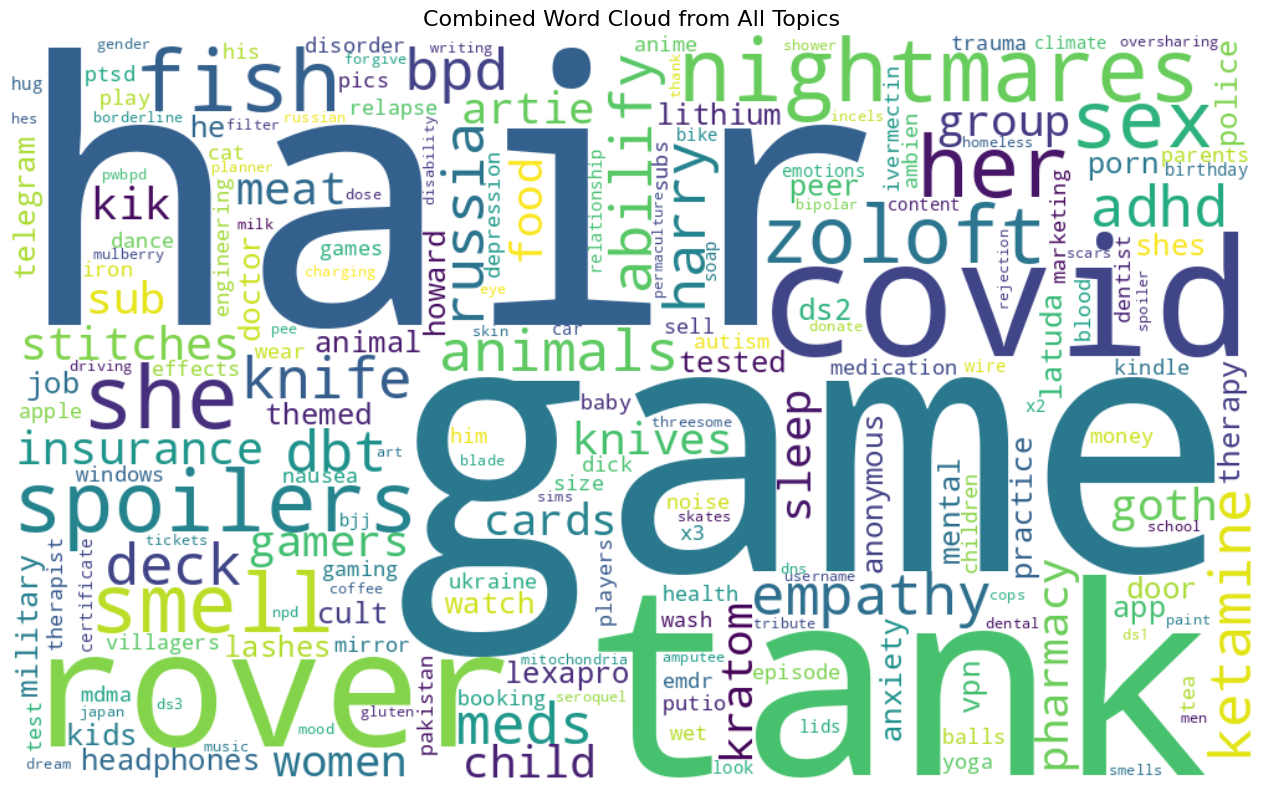

In [ ]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Define words to exclude
excluded_words = {"discord", "server", "water"}

# Combine keywords from all topics except -1
all_words = {}
valid_topic_ids = [tid for tid in topic_model.get_topic_freq()['Topic'].tolist() if tid != -1]

for topic_id in valid_topic_ids:
    words_probs = topic_model.get_topic(topic_id)
    for word, weight in words_probs:
        if word.lower() not in excluded_words:
            all_words[word] = all_words.get(word, 0) + float(weight)

# Generate and display word cloud
wordcloud = WordCloud(width=1000, height=600, background_color='white').generate_from_frequencies(all_words)

plt.figure(figsize=(14, 8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.title("Combined Word Cloud from All Topics", fontsize=16)
plt.tight_layout()
plt.show()


In [ ]:
df = df[df['topic'] != -1]
user_topic_counts = df.groupby(['user', 'topic']).size().reset_index(name='count')

top_n = 10
top_topics = topic_model.get_topic_freq().head(top_n)
bpd_topics = top_topics['Topic'].tolist()

# Compute BPD topic score
def compute_bpd_topic_score(group):
    total = group['count'].sum()
    bpd_total = group[group['topic'].isin(bpd_topics)]['count'].sum()
    return bpd_total / total if total > 0 else 0

bpd_scores = user_topic_counts.groupby('user').apply(compute_bpd_topic_score).reset_index(name='bpd_topic_score')
bpd_scores.to_csv("/content/bpd_topic_scores_topN.csv", index=False)


<ipython-input-13-17dc95c4a0e6>:14: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  bpd_scores = user_topic_counts.groupby('user').apply(compute_bpd_topic_score).reset_index(name='bpd_topic_score')
